In [81]:
# import
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from orakl.attr import RandomSamplingPool

sns.set()
tf.random.set_seed(1024)
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 2.0.0
Eager execution: True


In [75]:
# download dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train / 255
x_test = x_test / 255

x_train_pool = x_train[100:]
y_train_pool = y_train[100:]

def create_mnist_dataset(data, labels, batch_size):
  def gen():
    for image, label in zip(data, labels):
        yield image, label
  ds = tf.data.Dataset.from_generator(gen, (tf.float32, tf.int32), ((28,28 ), ()))

  return ds.batch(batch_size)

#train and validation dataset with different batch size
train_dataset = create_mnist_dataset(x_train[:100], y_train[:100], 10)
valid_dataset = create_mnist_dataset(x_test[:500], y_test[:500], 32)

print(train_dataset)
print(valid_dataset)

<DatasetV1Adapter shapes: ((None, 28, 28), (None,)), types: (tf.float32, tf.int32)>
<DatasetV1Adapter shapes: ((None, 28, 28), (None,)), types: (tf.float32, tf.int32)>


In [100]:
def make_model():
  initializer = tf.initializers.he_normal(seed=0)
  model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64,
                          activation=tf.nn.relu,
                          input_shape=(28*28,),
                          kernel_initializer=initializer,
                          bias_initializer=initializer),  # input shape required
    tf.keras.layers.Dense(32,
                          activation=tf.nn.relu,
                          kernel_initializer=initializer,
                          bias_initializer=initializer),
    tf.keras.layers.Dense(10,
                          kernel_initializer=initializer,
                          bias_initializer=initializer)
  ])

  return model

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

def loss(model, x, y):
  y_ = model(x)

  return loss_object(y_true=y, y_pred=y_)

def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

In [101]:
def train_loop(model, train_dataset):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    for i, (x, y) in enumerate(train_dataset):
        # Optimize the model
        loss_value, grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Track progress
        epoch_loss_avg(loss_value)  # Add current batch loss
        # Compare predicted label to actual label
        epoch_accuracy(y, model(x))

    return epoch_loss_avg, epoch_accuracy

def val_loop(model, valid_dataset):
    valid_accuracy = tf.keras.metrics.Accuracy()
    for (x, y) in valid_dataset:
        logits = model(x)
        prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
        valid_accuracy(prediction, y)

    return valid_accuracy

In [113]:
def train(train_dataset, valid_dataset, sampling_strategy=None, n_samples=10):
  model = make_model()

  valid_accuracy_results = []
  num_epochs = 51
  excluded_indexes = []

  # training loop
  for epoch in range(num_epochs):
    epoch_loss_avg, epoch_accuracy = train_loop(model, train_dataset)

    if epoch % 10 == 0:
      print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                  epoch_loss_avg.result(),
                                                                  epoch_accuracy.result()))

      # validation loop                                                            
      valid_accuracy = val_loop(model, valid_dataset)
      print("Valid set accuracy: {:.3%}".format(valid_accuracy.result()))
      valid_accuracy_results.append(valid_accuracy.result())

      if sampling_strategy is not None:
        indexes, samples = sampling_strategy(model,
                                             data_pool=x_train_pool,
                                             n_samples=n_samples,
                                             excluded_indexes=excluded_indexes)
        excluded_indexes.append(indexes)
        additional_dataset = create_mnist_dataset(x_train_pool[indexes], y_train_pool[indexes], 10)
        train_dataset = train_dataset.concatenate(additional_dataset)
      
  return valid_accuracy_results

In [115]:
naive_results = train(train_dataset, valid_dataset, sampling_strategy=None)
random_results = train(train_dataset, valid_dataset, sampling_strategy=RandomSamplingPool())

Epoch 000: Loss: 2.296, Accuracy: 13.000%
Valid set accuracy: 10.200%
Epoch 010: Loss: 1.225, Accuracy: 80.000%
Valid set accuracy: 49.000%
Epoch 020: Loss: 0.636, Accuracy: 93.000%
Valid set accuracy: 56.800%
Epoch 030: Loss: 0.341, Accuracy: 97.000%
Valid set accuracy: 57.800%
Epoch 040: Loss: 0.197, Accuracy: 100.000%
Valid set accuracy: 60.000%
Epoch 050: Loss: 0.127, Accuracy: 100.000%
Valid set accuracy: 60.600%
Epoch 000: Loss: 2.296, Accuracy: 13.000%
Valid set accuracy: 10.200%
Epoch 010: Loss: 1.175, Accuracy: 80.000%
Valid set accuracy: 49.600%
Epoch 020: Loss: 0.644, Accuracy: 90.833%
Valid set accuracy: 57.200%
Epoch 030: Loss: 0.383, Accuracy: 95.385%
Valid set accuracy: 63.200%
Epoch 040: Loss: 0.250, Accuracy: 97.857%
Valid set accuracy: 64.800%
Epoch 050: Loss: 0.165, Accuracy: 99.333%
Valid set accuracy: 65.200%


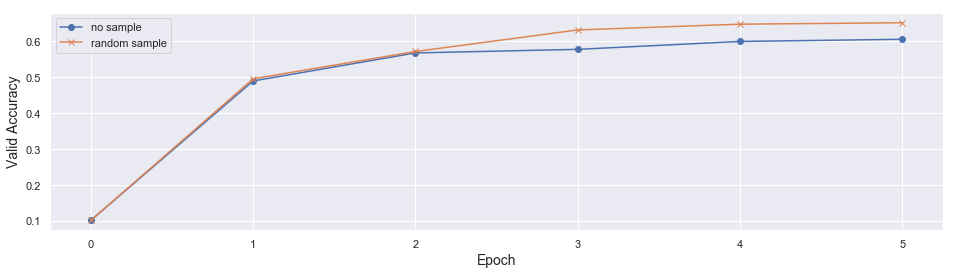

In [121]:
fig, axes = plt.subplots(1, sharex=True, figsize=(16, 4))

axes.set_ylabel("Valid Accuracy", fontsize=14)
axes.set_xlabel("Epoch", fontsize=14)
axes.plot(naive_results, marker="o", label="no sample")
axes.plot(random_results, marker="x", label="random sample")
axes.legend()
plt.show()